# Computer Vision

In [9]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
%matplotlib inline

# Session 5

Deep Learning Model for differentiating between 10 animals (PyTorch)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "Animal_10_simplified"

We're using => cpu


In [6]:
image_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])
}

animal_10 = datasets.ImageFolder(root = root_dir + "//train",transform = image_transforms["train"])
animal_10.class_to_idx

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [7]:
animal_10_size = len(animal_10)
animal_10_indices = list(range(animal_10_size))

print(animal_10_size)

300


In [8]:
np.random.shuffle(animal_10_indices)

val_split_index = int(np.floor(0.2 * animal_10_size))
train_idx, val_idx = animal_10_indices[val_split_index:], animal_10_indices[:val_split_index]

In [16]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

class_names = animal_10.classes
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [10]:
train_loader = DataLoader(dataset=animal_10, shuffle=False, batch_size=2, sampler=train_sampler)
val_loader = DataLoader(dataset=animal_10, shuffle=False, batch_size=2, sampler=val_sampler)

In [17]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.008)

In [12]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [18]:
print("Begin training.")
for epoch in range(5):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    print('Done Epoch')
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    torch.save(model,'animal10.pth')
    
print('model saved')

Begin training.
Done Epoch
Epoch 00: | Train Loss: 2.67660 | Val Loss: 2.31860 | Train Acc: 10.833| Val Acc: 21.667
model saved
Done Epoch
Epoch 01: | Train Loss: 2.33212 | Val Loss: 1.54555 | Train Acc: 14.583| Val Acc: 56.667
model saved
Done Epoch
Epoch 02: | Train Loss: 2.07533 | Val Loss: 1.28864 | Train Acc: 27.917| Val Acc: 55.000
model saved
Done Epoch
Epoch 03: | Train Loss: 1.76554 | Val Loss: 1.12842 | Train Acc: 36.250| Val Acc: 61.667
model saved
Done Epoch
Epoch 04: | Train Loss: 1.75703 | Val Loss: 1.06959 | Train Acc: 42.083| Val Acc: 63.333
model saved


In [19]:
m= torch.load('animal10.pth')
m.eval().cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
def predict_show(path):
    img=Image.open(path)
    img_tensor=image_transforms['test'](img).unsqueeze(0)
    pred = m(img_tensor)

    y_pred_softmax = torch.log_softmax(pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
    print(y_pred_softmax)
    print(y_pred_tags)
    print("prediction is: " , class_names[y_pred_tags])
    plt.imshow(img)

tensor([[-2.3532e-03, -9.9987e+00, -1.0937e+01, -9.8278e+00, -9.4266e+00,
         -1.0823e+01, -1.3183e+01, -8.7779e+00, -6.2297e+00, -1.1921e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([0])
prediction is:  butterfly


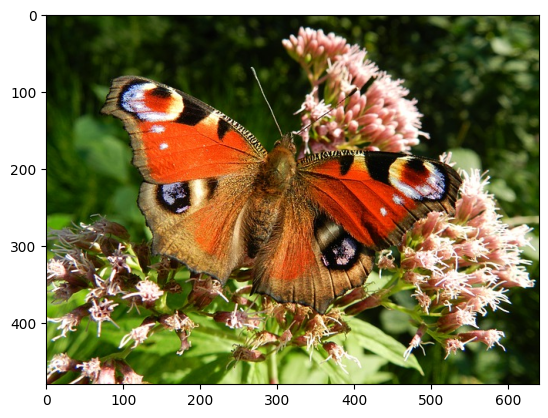

In [28]:
predict_show('Animal_10_simplified/test/butterfly2.jpg')

tensor([[-6.3326, -0.1287, -5.9881, -5.6008, -3.0916, -5.4939, -6.6940, -3.2952,
         -6.7842, -3.7368]], grad_fn=<LogSoftmaxBackward0>)
tensor([1])
prediction is:  cat


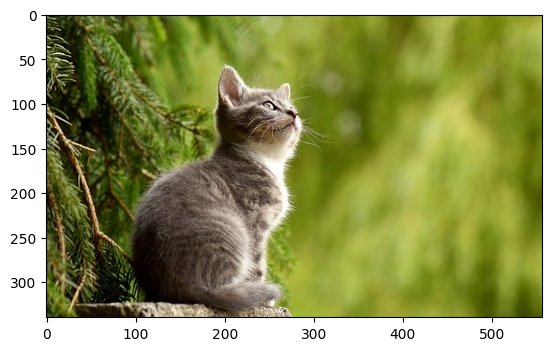

In [53]:
predict_show('Animal_10_simplified/test/cat1.jpg')

tensor([[-3.0412, -4.3371, -0.2983, -2.5876, -3.7868, -6.0565, -4.2129, -3.6090,
         -3.3702, -3.8834]], grad_fn=<LogSoftmaxBackward0>)
tensor([2])
prediction is:  chicken


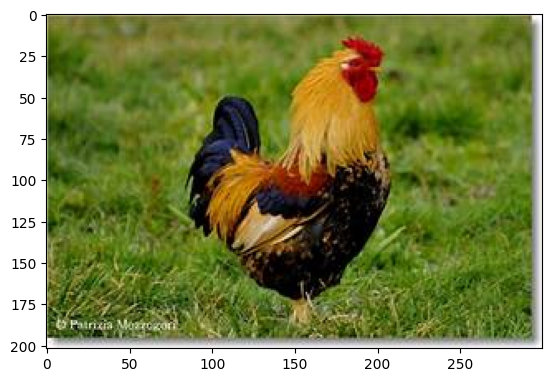

In [31]:
predict_show('Animal_10_simplified/test/chicken1.jpeg')

tensor([[-7.1359, -6.6747, -3.4319, -0.8862, -2.0958, -4.6329, -1.4465, -1.6915,
         -8.0366, -7.2351]], grad_fn=<LogSoftmaxBackward0>)
tensor([3])
prediction is:  cow


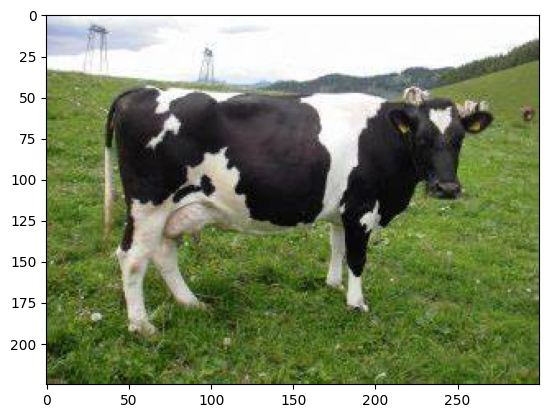

In [61]:
predict_show('Animal_10_simplified/test/cow1.jpeg')

tensor([[-6.9716, -3.8824, -7.2875, -2.8466, -0.4399, -2.7741, -1.7882, -3.1925,
         -6.0947, -5.9262]], grad_fn=<LogSoftmaxBackward0>)
tensor([4])
prediction is:  dog


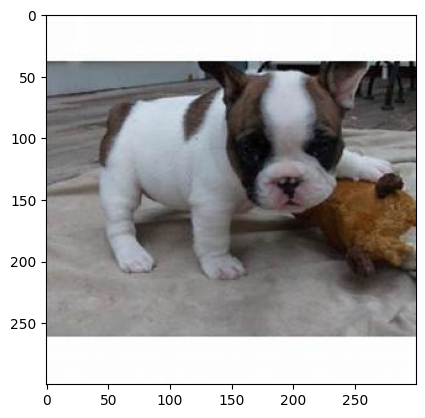

In [23]:
predict_show('Animal_10_simplified/test/dog1.jpeg')

tensor([[-1.2451e+01, -1.2681e+01, -1.1407e+01, -1.0173e+01, -1.2399e+01,
         -3.5362e-03, -9.6629e+00, -5.6963e+00, -1.0713e+01, -1.0587e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([5])
prediction is:  elephant


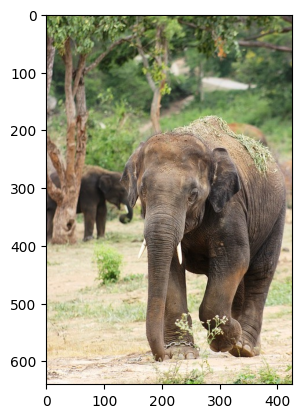

In [36]:
predict_show('Animal_10_simplified/test/elephant2.jpg')

tensor([[-5.0759, -5.8497, -5.9875, -4.1388, -4.1007, -3.5986, -0.0796, -6.4899,
         -6.2654, -6.4324]], grad_fn=<LogSoftmaxBackward0>)
tensor([6])
prediction is:  horse


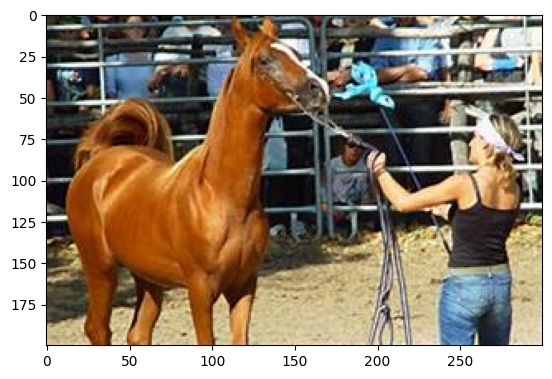

In [38]:
predict_show('Animal_10_simplified/test/horse2.jpeg')

tensor([[-1.2113e+01, -1.0776e+01, -7.1231e+00, -6.6897e+00, -6.2739e+00,
         -9.3263e+00, -8.6399e+00, -4.2716e-03, -1.2941e+01, -1.0320e+01]],
       grad_fn=<LogSoftmaxBackward0>)
tensor([7])
prediction is:  sheep


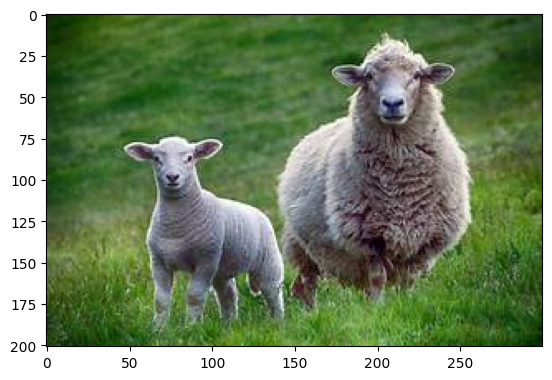

In [42]:
predict_show('Animal_10_simplified/test/sheep2.jpeg')

tensor([[ -4.3060,  -7.7739, -12.9492,  -7.3926,  -5.8740,  -9.1571,  -7.7830,
          -7.5532,  -0.0187,  -8.8163]], grad_fn=<LogSoftmaxBackward0>)
tensor([8])
prediction is:  spider


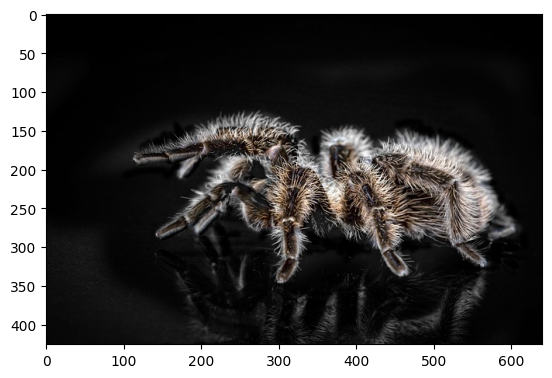

In [46]:
predict_show('Animal_10_simplified/test/spider1.jpg')

tensor([[-3.3331, -2.5119, -2.5465, -2.8773, -2.7236, -1.7496, -2.7576, -2.8726,
         -2.6788, -1.1381]], grad_fn=<LogSoftmaxBackward0>)
tensor([9])
prediction is:  squirrel


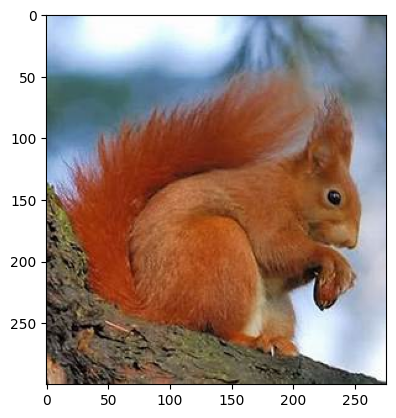

In [51]:
predict_show('Animal_10_simplified/test/squirrel2.jpeg')

# Session 6

Cat Vs Dog Detection (Yolo)

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\EGYPT_LAPTOP/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-26 Python-3.9.5 torch-1.13.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [5]:
!cd yolov5 && python train.py --img 320 --batch 16 --epochs 500 --data data.yaml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'D:\AMIT\Machine': No such file or directory
YOLOv5  2022-11-26 Python-3.9.5 torch-1.13.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

In [23]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp8/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\EGYPT_LAPTOP/.cache\torch\hub\master.zip
YOLOv5  2022-11-26 Python-3.9.5 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [26]:
for i in range(1,21):
    img = os.path.join('yolo_data' , 'test',str(i) + '.jpg')
    results = model(img)
    results.print()

image 1/1: 499x381 (no detections)
Speed: 12.0ms pre-process, 461.7ms inference, 1.0ms NMS per image at shape (1, 3, 640, 512)
image 1/1: 299x296 (no detections)
Speed: 15.0ms pre-process, 558.7ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 299x300 (no detections)
Speed: 15.0ms pre-process, 574.7ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 288x374 (no detections)
Speed: 11.0ms pre-process, 433.8ms inference, 0.0ms NMS per image at shape (1, 3, 512, 640)
image 1/1: 400x399 (no detections)
Speed: 16.0ms pre-process, 544.7ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)
image 1/1: 375x499 (no detections)
Speed: 11.0ms pre-process, 406.8ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)
image 1/1: 148x192 (no detections)
Speed: 9.0ms pre-process, 434.7ms inference, 1.0ms NMS per image at shape (1, 3, 512, 640)
image 1/1: 234x325 (no detections)
Speed: 8.0ms pre-process, 417.8ms inference, 1.0ms NMS per image at shape (1,

In [27]:
img = os.path.join('yolo_data' , 'test','17.jpg')
results = model(img)
results.print()

image 1/1: 399x228 1 dog
Speed: 10.0ms pre-process, 314.8ms inference, 1.0ms NMS per image at shape (1, 3, 640, 384)


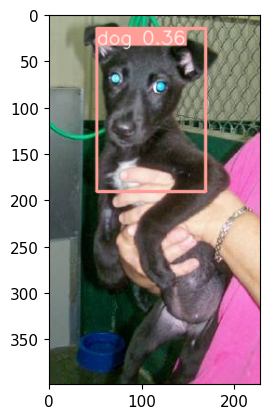

In [28]:
plt.imshow(np.squeeze(results.render()))

In [29]:
img = os.path.join('yolo_data' , 'test','20.jpg')
results = model(img)
results.print()

image 1/1: 232x356 1 cat
Speed: 9.0ms pre-process, 409.8ms inference, 1.0ms NMS per image at shape (1, 3, 448, 640)


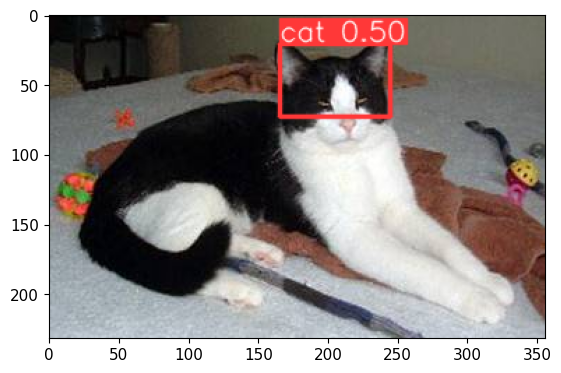

In [30]:
plt.imshow(np.squeeze(results.render()))

In [34]:
img = os.path.join('yolo_data' , 'test','12.jpg')
results = model(img)
results.print()

image 1/1: 465x315 1 dog
Speed: 10.0ms pre-process, 396.8ms inference, 1.0ms NMS per image at shape (1, 3, 640, 448)


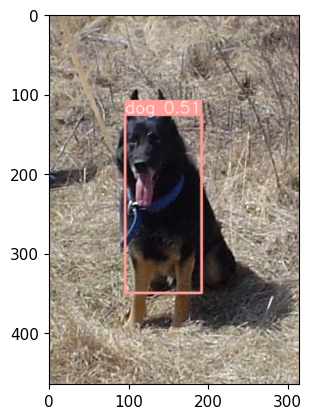

In [35]:
plt.imshow(np.squeeze(results.render()))